# Détection et reconnaissance des panneaux de signalisation
#### Aude Pertron, Jérémy Le Joncour

In [16]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

#### Définition de nos paths

In [2]:
from os import path, name

data_direction = "C:/Users/utilisateur/Documents/microsoft_ia/microsoft_ia/Panneau"
direction_train = "C:/Users/utilisateur/Documents/microsoft_ia/microsoft_ia/Panneau/Train"
direction_test = "C:/Users/utilisateur/Documents/microsoft_ia/microsoft_ia/Panneau/"

A la différence du brief sur la détection des masques, le nombre de classe des types de panneau est supérieur à 2. Un travail est donc réalisé afin de définir les catégories de nos datasets.

In [1]:
categories = { 0:'Vitesse limite (20km/h)',
                1:'Vitesse limite (30km/h)', 
                2:'Vitesse limite (50km/h)', 
                3:'Vitesse limite (60km/h)', 
                4:'Vitesse limite (70km/h)', 
                5:'Vitesse limite (80km/h)', 
                6:'Fin de limite de vitesse (80km/h)', 
                7:'Vitesse limite (100km/h)', 
                8:'Vitesse limite (120km/h)', 
                9:'Dépassement interdit sauf 2 roues', 
                10:'Dépassement interdit pour >3.5t', 
                11:'Priorité à droite à l\'intersection', 
                12:'Route prioritaire', 
                13:'Cédez le passage', 
                14:'Stop', 
                15:'Interdit aux véhicules', 
                16:'Veh >3.5t interdits', 
                17:'Sens interdit', 
                18:'Panneau danger', 
                19:'Virage dangereux à gauche', 
                20:'Virage dangereux à droite', 
                21:'Succession de virages', 
                22:'Cassis ou dos-d\'ânes', 
                23:'Route glissante', 
                24:'Chaussée rétrécie par la droite', 
                25:'Travaux', 
                26:'Feux tricolore', 
                27:'Passage piéton', 
                28:'Attention enfants', 
                29:'Attention vélos', 
                30:'Attention neige/verglas',
                31:'Passage animaux sauvages', 
                32:'Fin de toutes interdictions', 
                33:'Direction obligatoire à droite', 
                34:'Direction obligatoire à gauche', 
                35:'Direction obligatoire tout droit', 
                36:'Direction obligatoire tout droit ou à droite', 
                37:'Direction obligatoire tout droit ou gauche', 
                38:'Contournement obligatoire par la droite', 
                39:'Contournement obligatoire par la gauche', 
                40:'Giratoire', 
                41:'Fin de l\'interdiction de dépassement', 
                42:'Fin de l\'interdiction de dépassement >3.5t' }

In [85]:
num_categories = len(os.listdir(direction_train))
print(f'{num_categories} types de panneau sont comptabilisés')

43 types de panneau sont comptabilisés


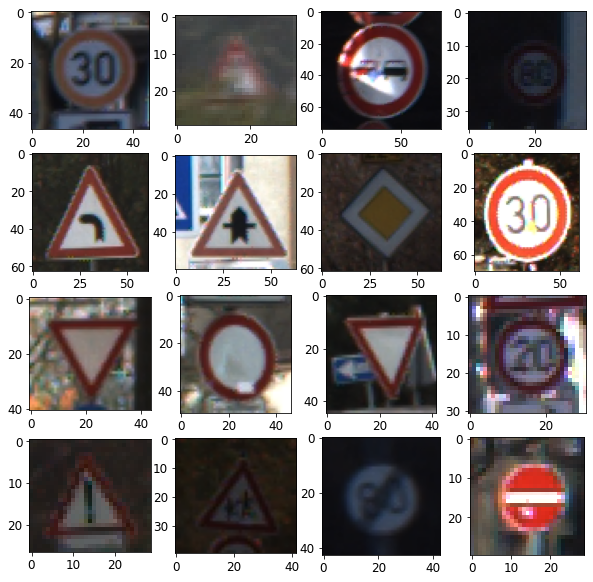

In [72]:
# Visualisation de 16 images aléatoires de nos données Test
import random
from matplotlib.image import imread

test = pd.read_csv(data_direction + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(10,10))

for i in range(1,17):
    plt.subplot(4,4,i)
    random_img_path = data_direction + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(False)

## Préparation de nos données Train

In [7]:
image_data = []
image_labels = []

for i in range(num_categories):
    # Direction vers chaque sous-dossier Train
    path = direction_train + '/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((23, 23))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Erreur sur " + img)

# Transformation des listes en Np.Array
image_data = np.array(image_data) # Données X
image_labels = np.array(image_labels) # Données Y

# Vérification des Dimensions
print(image_data.shape, image_labels.shape)

(39209, 23, 23, 3) (39209,)


## Création des features x et target y Apprentissage (app) et Evaluation (val)

#### Randomisation

In [8]:
shuffle_indexes = ssssSnp.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

#### Vérification des dimensions et split des données Train en données d'Apprentissage et d'Evaluation

In [14]:
x_app, x_val, y_app, y_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=42, shuffle=True)

x_app = x_app/255 
x_val = x_val/255

print("x_app.shape :\t ", x_app.shape)
print("x_val.shape :\t ", x_val.shape)
print("y_app.shape :\t ", y_app.shape)
print("y_val.shape :\t ", y_val.shape)

x_app.shape :	  (31367, 23, 23, 3)
x_val.shape :	  (7842, 23, 23, 3)
y_app.shape :	  (31367,)
y_val.shape :	  (7842,)


#### One Hot Encoding sur les labels y

Lors du lancement du premier modèle, un erreur est survenue sur les dimensions des Targets. Nous utilisons le One hot encoding de Keras pour redimensionner les labels.

In [18]:
y_app = keras.utils.to_categorical(y_app, 43)
y_val = keras.utils.to_categorical(y_val, 43)

print("y_app.shape :\t ",y_app.shape)
print("y_val.shape :\t ",y_val.shape)

y_app.shape :	  (31367, 43)
y_val.shape :	  (7842, 43)


## Création du modèle CNN

In [20]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(23, 23, 3)))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))

model.add(tf.keras.layers.Dense(43, activation='softmax'))

Notre modèle contient 3 couches :

* Pour l'initialisation de notre modèle, les couches Conv2D sont utilisées sur les traitements d'objets bidimensionnelles, et contiennent différentes classes comme les filtres (dont le nombre augmente vers les couches de sortie), avec une définition de  kernel de dimension (3,3) idéale pour des images ayant une taille inférieure à *128x128* pixels. L'input_shape reprend les dimensions des images que nous fournissons à notre modèle (*23x23* pixels en 3 couleurs RGB). Enfin, nous avons définis une activation reLU, l'activation linéaire standard qui permet de fixer les valeurs négatives de nos matrices à 0. MaxPooling2D réduit les dimensions des images injectées et conserve les traits principaux.


* Les dernières couches Flatten et Dense font la liaison entre les couches précédentes et convertissent les données en matrice à 1 dimension. Le but de Dropout est d'aider le réseau à se généraliser et peut régler les problèmes de sur-apprentissage. Les neurones de la couche actuelle, avec une probabilité ici de 0.5, déconnecteront de manière aléatoire des neurones de la couche suivante afin que le réseau doive s'appuyer sur les connexions existantes. 

Nous utilisons enfin l'activation Softmax, performant pour la multiclassification.

#### Compilation

In [21]:
model.compile(optimizer ='adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

#### Paramètres

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 21, 21, 16)        448       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 19, 19, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)              

#### Augmentation du set de données d'apprentissage

In [23]:
augmentation = ImageDataGenerator(rotation_range=10,
                                zoom_range=0.15,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.15,
                                horizontal_flip=False,
                                vertical_flip=False,
                                fill_mode="nearest")

ImageDataGenerator réalise de la data augmentation, permettant l'augmentation de la taille du set d'apprentissage en rajoutant des effets sur les images existantes (inclinaisons, flou, changements de luminosité....)

### Entrainement

In [24]:
# history = model.fit(augmentation.flow(x_app, y_app, batch_size=32), epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
981/981 [==============================] - 44s 43ms/step - loss: 2.5557 - accuracy: 0.2951 - val_loss: 0.2727 - val_accuracy: 0.9153
Epoch 2/10
981/981 [==============================] - 43s 44ms/step - loss: 0.4970 - accuracy: 0.8409 - val_loss: 0.0853 - val_accuracy: 0.9774
Epoch 3/10
981/981 [==============================] - 109s 112ms/step - loss: 0.2559 - accuracy: 0.9190 - val_loss: 0.0415 - val_accuracy: 0.9861
Epoch 4/10
981/981 [==============================] - 107s 109ms/step - loss: 0.1566 - accuracy: 0.9516 - val_loss: 0.0255 - val_accuracy: 0.9931
Epoch 5/10
981/981 [==============================] - 107s 109ms/step - loss: 0.1240 - accuracy: 0.9606 - val_loss: 0.0202 - val_accuracy: 0.9946
Epoch 6/10
981/981 [==============================] - 114s 117ms/step - loss: 0.1003 - accuracy: 0.9686 - val_loss: 0.0269 - val_accuracy: 0.9932
Epoch 7/10
981/981 [==============================] - 104s 106ms/step - loss: 0.0875 - accuracy: 0.9734 - val_loss: 0.0197 - val

#### Evaluation du modèle (Historique)

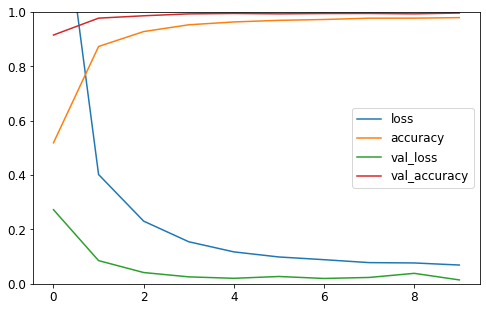

In [71]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(False)
plt.gca().set_ylim(0, 1)
plt.show()

Notre Score de Précision atteint près de 98%, et celui réalisé sur nos données de Validation près de 1. Obtenant des résultats satisfaisants, nous pouvons tester notre modèle sur nos données de Test, n'ayant pas servi à l'entraînement de ce dernier.

## Chargement des données Test

In [36]:
test = pd.read_csv('Test.csv')
test

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,Test/12625.png
12626,50,51,6,5,45,46,33,Test/12626.png
12627,29,29,6,6,24,24,6,Test/12627.png
12628,48,49,5,6,43,44,7,Test/12628.png


In [43]:
y_test = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_direction + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((23, 23))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)

#### Evaluation sur notre modèle avec les données Test

In [44]:
x_test = np.array(data)
x_test = x_test/255

y_pred = model.predict_classes(x_test)

print('Précision sur les données Test : ', accuracy_score(y_test, y_pred))

Précision sur les données Test :  0.9708630245447347


La précision de notre modèle sur nos données Test atteint 97%. Nous pouvons visualiser la classification de ces images à travers une matrice de confusion.

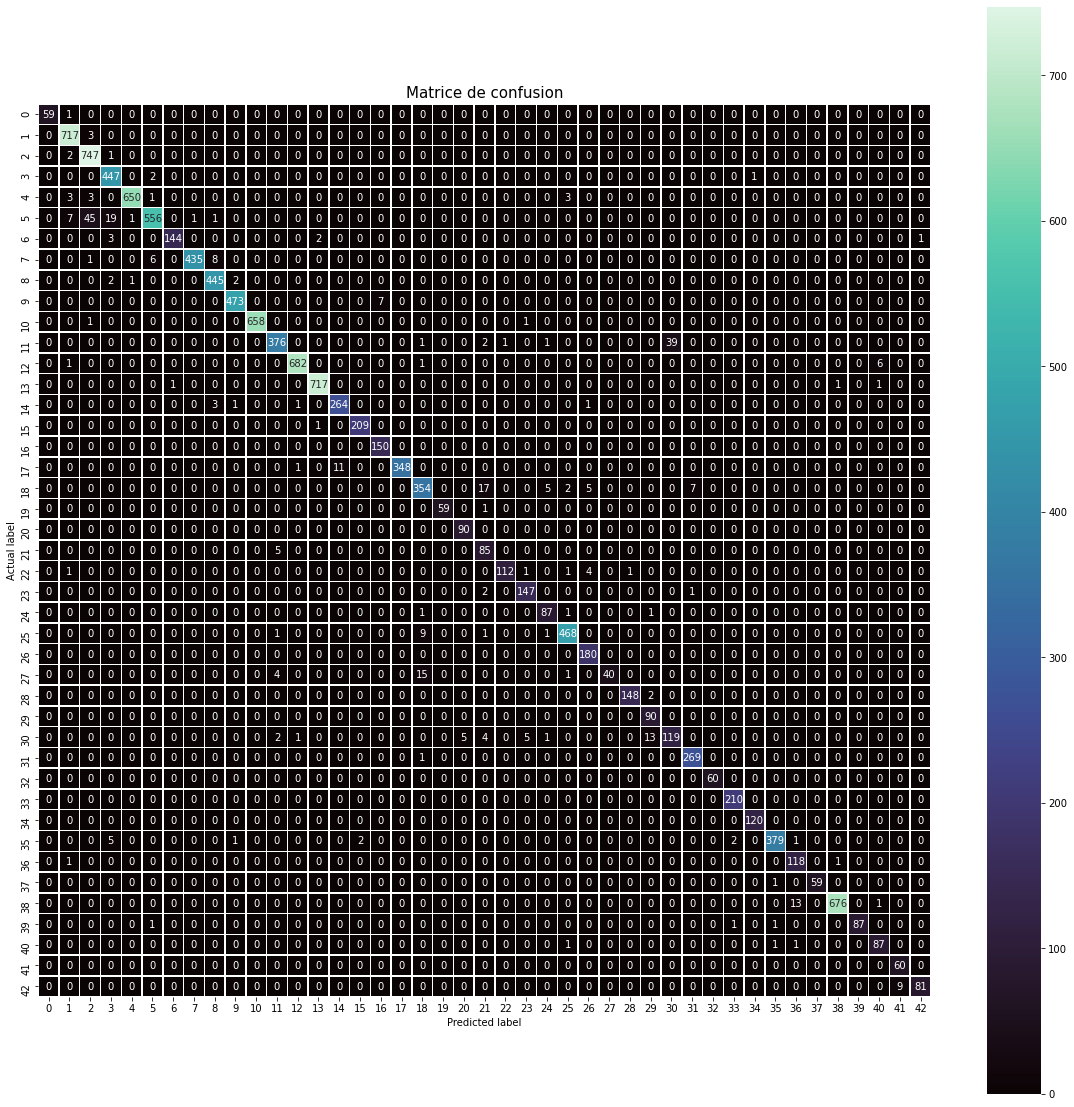

In [49]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

c_m = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20,20))
sns.heatmap(c_m, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'mako');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Matrice de confusion", size = 15)
plt.show()

#### Visualisation

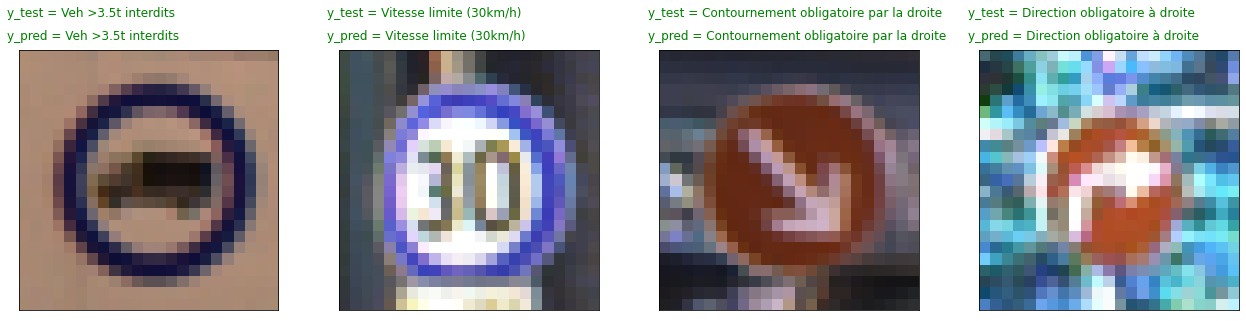

In [86]:
plt.figure(figsize = (22, 22))
font = {'size': 12}
plt.rc('font', **font)

start_index = 0
for i in range(4):
    plt.subplot(4, 4, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = categories[y_pred[start_index + i]]
    actual = categories[y_test[start_index + i]]
    col = 'g'
    if prediction != actual:
        col = 'r'
    #plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.text(-1.5, -3.5, f'y_test = {actual}', color = col)
    plt.text(-1.5, -1.5, f'y_pred = {prediction}', color = col)
    plt.imshow(x_test[start_index + i])
plt.show()

In [68]:
# model.save("model")

INFO:tensorflow:Assets written to: model\assets
